In [1]:
import re
import math
import pickle
import requests
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from time import time
import IPython.display as Disp
from wordcloud import WordCloud
from sklearn.metrics.pairwise import cosine_similarity
from gensim import corpora, models, similarities
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from underthesea import word_tokenize
from operator import itemgetter
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)

In [2]:
df_org = pd.read_csv('2k_data_Sep.csv')
df = df_org.copy()
df.shape

(2000, 8)

In [3]:
def clean_function(text):  
    #lowercase
    text = text.lower()
    
#     #xoá ký tự đặc biệt, ký tự không phải alphanumeric 
#     text = re.sub("[^a-z0-9àáạảãâầấậẩẫăằắặẳẵèéẹẻẽêềếệểễòóọỏõôồốộổỗơờớợởỡìíịỉĩùúụủũưừứựửữỳýỵỷỹđ]",' ', text)
    text = re.sub("[\àáạảãâầấậẩẫăằắặẳẵèéẹẻẽêềếệểễòóọỏõôồốộổỗơờớợởỡìíịỉĩùúụủũưừứựửữỳýỵỷỹđ]",'', text)    
#     #xoá leading zero
#     text = [e.lstrip('0') for e in text.split(' ')]
#     text = (' ').join(text)
    
    #replace extra spaces with single space
    text = re.sub(' +',' ',text)
    
    #xoá khoảng trắng ở đầu và cuối mỗi câu
    text = text.strip()
    
    #word tokenzie
    text = word_tokenize(text, format='text')
    return text

In [4]:
df['index_org'] = df.index
df['clean_lookup'] = df['Lookup Text'].map(lambda x: clean_function(x))
df['clean_question'] = df['Question Text'].map(lambda x: clean_function(x))

df['char_count_lookup'] = df['clean_lookup'].str.len()
df['word_count_lookup'] = df['clean_lookup'].str.split().str.len()
df['average_word_length_lookup'] = df['char_count_lookup'] / df['word_count_lookup']

df['char_count_question'] = df['clean_question'].str.len()
df['word_count_question'] = df['clean_question'].str.split().str.len()
df['average_word_length_question'] = df['char_count_question'] / df['word_count_question']

In [5]:
check_dup = df[['Lookup Text', 'Question Text']][df[['Lookup Text', 'Question Text']].duplicated()]
df = df.drop(check_dup.index)
df = df.reset_index(drop = True)
df.shape

(1962, 17)

In [6]:
with open('vietnamese-stopwords.txt', 'r', encoding='utf-8') as file:
    vn_stop_words = file.read()
vn_stop_words = vn_stop_words.split('\n') 

# combine Vietnamese stopwords and English stopwords
stop_words = ENGLISH_STOP_WORDS.union(vn_stop_words)

In [7]:
def cosine_search(query, tf, tfidf_matrix, data, top_result = 5, check_time = True):
    t0 = time()
    query = clean_function(query)
    query_tf = tf.transform([query])
    query_tf = pd.DataFrame(query_tf.toarray(),
                            columns = tf.get_feature_names())
    
    cosine_sim = cosine_similarity(query_tf, tfidf_matrix).flatten()
    
    related_question = cosine_sim.argsort()[-top_result:][::-1]
    
    cosine_sim = sorted(cosine_sim, reverse = True)
    similarities_score = cosine_sim[:top_result]
    
    result = pd.DataFrame({'question_text': data.iloc[related_question, :]['Question Text'].values,
                           'sim_score': similarities_score})
    if check_time:
        print('Time:', time() - t0)
    return result

In [8]:
tf_question = TfidfVectorizer(analyzer = 'word', stop_words = stop_words, max_features = 1200)
tfidf_question = tf_question.fit_transform(df['clean_question'])
tfidf_question = pd.DataFrame(tfidf_question.toarray(),
                            columns = tf_question.get_feature_names())
tfidf_question.shape

(1962, 1200)

In [9]:
def cosine_search_all(queries, tf, tfidf_matrix, data, top_result = 5, check_time = True):
    t0 = time()
    results = []
    for i in range(0, len(queries)):
        query = clean_function(queries[i])
        query_tf = tf.transform([query])
        query_tf = pd.DataFrame(query_tf.toarray(),
                                columns = tf.get_feature_names())
        cosine_sim = cosine_similarity(query_tf, tfidf_matrix.iloc[[i]]).flatten()
        results.append(cosine_sim[0])
    times = time() - t0
    if check_time:
        if times < 60:
            print('Cosine search took {:.2f}s.'.format(times))
        else:
            print('Cosine search took {:.2f} minutes.'.format(times / 60))
    return results

In [10]:
cosine_score = cosine_search_all(df['Lookup Text'].values, tf_question, tfidf_question, df)

Cosine search took 15.13s.


In [11]:
df['score'] = cosine_score

In [27]:
mask1 = df['Human Feedback'] == 'NOT MATCH'
mask2 = df['Human Feedback'] == 'MATCH'

df_neg = df[mask1].reset_index(drop = True)
df_pos = df[mask2].reset_index(drop = True)

print(df_neg.shape)
print(df_pos.shape)

(966, 21)
(996, 21)


In [25]:
df['diff_word'] = abs(df['word_count_question'] - df['word_count_lookup'])
df_neg['diff_word'] = abs(df_neg['word_count_question'] - df_neg['word_count_lookup'])
df_pos['diff_word'] = abs(df_pos['word_count_question'] - df_pos['word_count_lookup'])

my_bins = [-np.inf, 5, 10, 15, 20, np.inf]
my_labels = ['Very low', 'Low', 'Medium', 'High', 'Very high']

df['diff_bin'] = pd.cut(df['diff_word'], bins=my_bins, labels=my_labels)
df_neg['diff_bin'] = pd.cut(df_neg['diff_word'], bins=my_bins, labels=my_labels)
df_pos['diff_bin'] = pd.cut(df_pos['diff_word'], bins=my_bins, labels=my_labels)

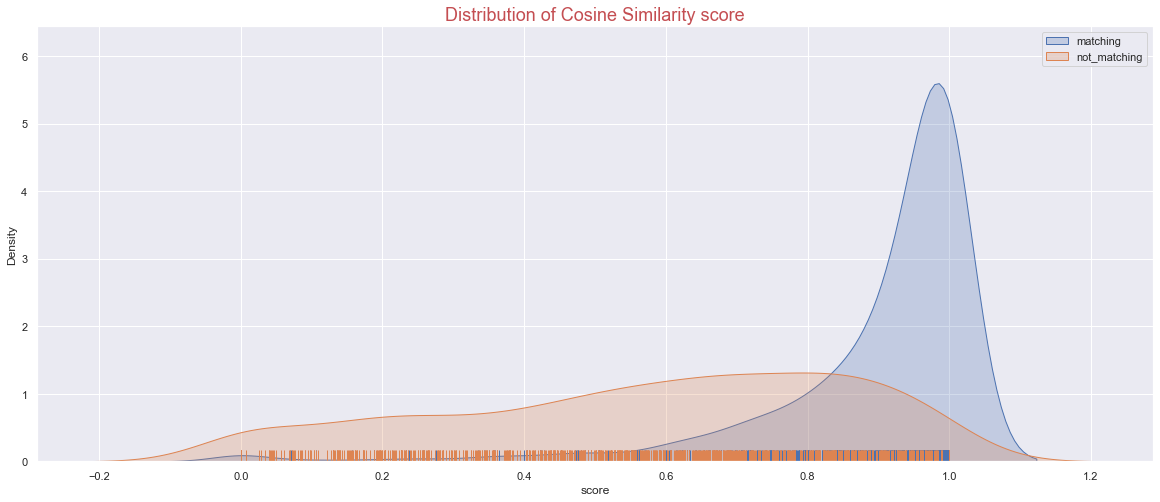

In [15]:
sb.set_theme()
plt.figure(figsize=(20, 8))
sb.distplot(df_pos.score, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = 'matching')
sb.distplot(df_neg.score, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = 'not_matching')
plt.legend()
plt.title('Distribution of Cosine Similarity score', fontsize = 18, color = 'r');

In [17]:
df.loc[df['score'] >= 0.8].shape

(1089, 20)

In [20]:
def jaccard_search(query_matrix, source_matrix, check_time = True):
#     #Load data
#     df_product = pd.read_csv('data/product_names_clean.csv', index_col=0)
    
    t0=time()
    results = []
       
    for q1, q2 in zip(query_matrix, source_matrix):
        words_doc1 = set(q1.lower().split()) 
        words_doc2 = set(q2.lower().split())

        # Find the intersection of words list of doc1 & doc2
        intersection = words_doc1.intersection(words_doc2)

        # Find the union of words list of doc1 & doc2
        union = words_doc1.union(words_doc2)

        # Calculate Jaccard similarity score 
        # using length of intersectioEm n set divided by length of union set
        jaccard_score = len(intersection) / len(union)
        results.append(jaccard_score)
    times = time() - t0
    if check_time:
        if times < 60:
            print('Jaccard search took {:.2f}s.'.format(times))
        else:
            print('Jaccard search took {:.2f} minutes.'.format(times / 60))
    return results

In [28]:
jc_score = jaccard_search(df['clean_lookup'].values, df['clean_question'].values)

Jaccard search took 0.06s.


In [29]:
df['jc_score'] = jc_score

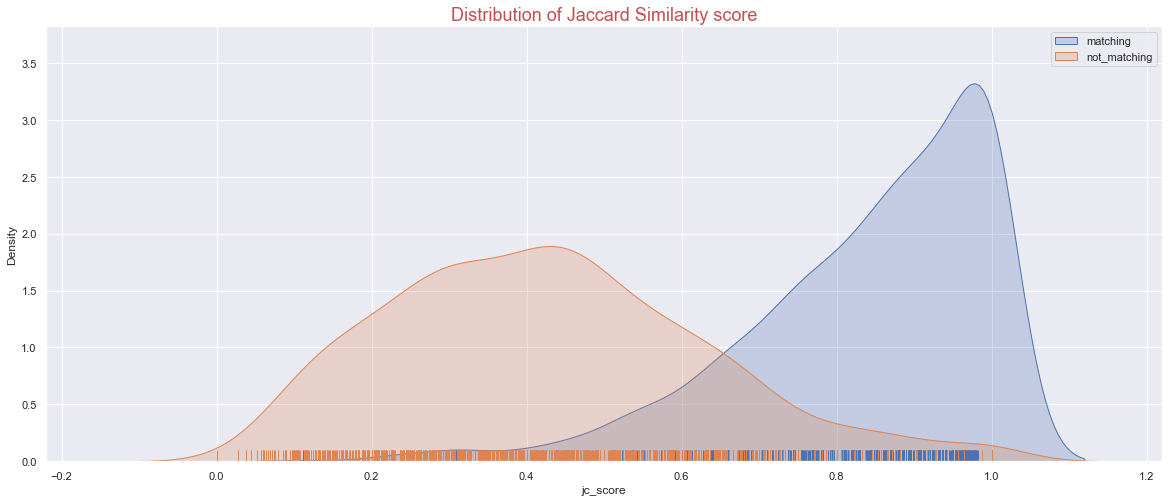

In [30]:
plt.figure(figsize=(20, 8))
sb.distplot(df_pos.jc_score, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = 'matching')
sb.distplot(df_neg.jc_score, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = 'not_matching')
plt.legend()
plt.title('Distribution of Jaccard Similarity score', fontsize = 18, color = 'r');

In [33]:
df.loc[df['jc_score'] >= 0.8].shape

(721, 21)

In [47]:
1-.612-.329-.003

0.055999999999999994

In [51]:
(.164+.534*4+.289*9)-2.099

2.8019999999999996

In [57]:
.5+16*.2 - 1.3

2.4000000000000004

In [60]:
from pylatexenc.latex2text import LatexNodes2Text

In [70]:
latex = df.iloc[3]['Lookup Text']
latex

'Câu 49: Cho hàm số \\( y=f(x) \\) có đạo hàm là \\( f^{\\prime}(x)=(x-1)\\left(x^{2}-4\\right)(x+10) \\), với moi \\( x \\in R \\). Có tất cả bao nhiêu giá trị nguyên của tham số \\( m \\) đề hàm số \\( g(x)=f\\left(|x|^{3}+3|x|-3 m-m^{2}\\right) \\) có đúng 7 điểm cực trị?\nA. 3 .\nB. 4 .\nC. 6\nD. 5 .'

In [71]:
text = LatexNodes2Text().latex_to_text(latex)
text

"Câu 49: Cho hàm số y=f(x) có đạo hàm là f^'(x)=(x-1)(x^2-4)(x+10), với moi x ∈ R. Có tất cả bao nhiêu giá trị nguyên của tham số m đề hàm số g(x)=f(|x|^3+3|x|-3 m-m^2) có đúng 7 điểm cực trị?\nA. 3 .\nB. 4 .\nC. 6\nD. 5 ."

In [69]:
df_new = df_org.iloc[:, 1:6]
df_new.head()

,Lookup Text,Question Text,Feedback Type,Feedback Result,Human Feedback
0,b) \( \left(\frac{-4}{15}-\frac{18}{19}\right)-\left(\frac{20}{19}-\frac{11}{15}\right) \),a) \( \frac{2}{3}+\frac{-1}{3}+\frac{7}{15} \)\nd) \( \frac{3}{5}+\frac{1}{5} \cdot \frac{-17}{9} \)\nb) \( \left(\frac{-4}{15}-\frac{18}{19}\right)-\left(\frac{20}{19}-\frac{11}{15}\right) \)\nc) \( \left(\frac{9}{10}-\frac{15}{16}\right) \cdot\left(\frac{5}{12}-\frac{11}{15}-\frac{7}{20}\right) \)\ne) \( \left(\frac{-3}{4}+\frac{2}{5}\right): \frac{3}{7}+\left(\frac{3}{5}+\frac{-1}{4}\right): \frac{3}{7} \),NEGATIVE,MATCH,NOT MATCH
1,Đề số \( 1 . \)\n1. Tính\nb) \( \sqrt{25} \)\nc) \( \sqrt{-36} \)\na) \( \sqrt{64} \)\ne) \( \sqrt{(-5)^{2}} \)\nd) \( \sqrt{5^{2}} \)\nf) \( \frac{2}{3} \sqrt{81}-\left(-\frac{3}{4}\right): \sqrt{\frac{9}{64}}+\left(\frac{\sqrt{2}}{\sqrt{3}}\right)^{0}-(\sqrt{3})^{2} \),b) \( \sqrt{25} \)\nc) \( \sqrt{-36} \)\na) \( \sqrt{64} \)\n\( 0=\frac{2 s}{\partial s} \) e) \( \sqrt{(-5)^{2}} \)\nd) \( \sqrt{5^{2}} \)\nf) \( \frac{2}{3} \sqrt{81}-\left(-\frac{3}{4}\right): \sqrt{\frac{9}{64}}+\left(\frac{\sqrt{2}}{3}\right)^{0}-(\sqrt{3})^{2} \),NEGATIVE,MATCH,MATCH
2,1. Tính: \( \sqrt{\frac{25}{4}}+\left(\sqrt{\frac{1}{2}}\right)^{2}:\left(\frac{-\sqrt{9}}{4}\right) \cdot \sqrt{\frac{16}{81}}-3^{2}-(-2)^{2} \),Đề số \( 3 . \)\n1. Tính: \( \sqrt{\frac{25}{4}}+\left(\sqrt{\frac{1}{2}}\right)^{2}:\left(\frac{-\sqrt{9}}{4}\right) \cdot \sqrt{\frac{16}{81}}-3^{2}-(-2)^{2} \),POSITIVE,MATCH,MATCH
3,"Câu 49: Cho hàm số \( y=f(x) \) có đạo hàm là \( f^{\prime}(x)=(x-1)\left(x^{2}-4\right)(x+10) \), với moi \( x \in R \). Có tất cả bao nhiêu giá trị nguyên của tham số \( m \) đề hàm số \( g(x)=f\left(|x|^{3}+3|x|-3 m-m^{2}\right) \) có đúng 7 điểm cực trị?\nA. 3 .\nB. 4 .\nC. 6\nD. 5 .",Câu 49. Cho hàm số \( y=f(x) \) có đạo hàm \( f^{\prime}(x)=(x+1)^{2}(x+3)\left(x^{2}+2 m x+5\right) \) với mọi \( x \in R \). Có bao nhiêu giá trị nguyên âm của tham số \( m \) để hàm số \( g(x)=f(|x|) \) có đúng 1 điểm cực trị?\nA. 2 .\nB. 5 .\nC. 4 .\nD. 3 .,NEGATIVE,NOT_MATCH,NOT MATCH
4,b. Giải phương trình: \( 2 \sin ^{2} x+\sqrt{3} \sin 2 x+1=3(\cos x+\sqrt{3} \sin x) \).,1) \( \sin ^{2} 2 x-(2+\sqrt{3}) \sin 2 x+\sqrt{3}+1=C \),NEGATIVE,NOT_MATCH,NOT MATCH


In [72]:
df['lookup_plain'] = df['Lookup Text'].map(lambda x: LatexNodes2Text().latex_to_text(x))
df['question_plain'] = df['Question Text'].map(lambda x: LatexNodes2Text().latex_to_text(x))

In [76]:
df['clean_lookup_plain'] = df['lookup_plain'].map(lambda x: clean_function(x))
df['clean_question_plain'] = df['question_plain'].map(lambda x: clean_function(x))

In [78]:
tf_question = TfidfVectorizer(analyzer = 'word', stop_words = stop_words, min_df=0)
tfidf_question = tf_question.fit_transform(df['clean_question_plain'])
tfidf_question = pd.DataFrame(tfidf_question.toarray(),
                            columns = tf_question.get_feature_names())
tfidf_question.shape

(1962, 3749)

In [79]:
cosine_new = cosine_search_all(df['lookup_plain'].values, tf_question, tfidf_question, df)

Cosine search took 14.90s.


In [84]:
df['cosine_new'] = cosine_new

In [85]:
mask1 = df['Human Feedback'] == 'NOT MATCH'
mask2 = df['Human Feedback'] == 'MATCH'

df_neg = df[mask1].reset_index(drop = True)
df_pos = df[mask2].reset_index(drop = True)

print(df_neg.shape)
print(df_pos.shape)

(966, 26)
(996, 26)


In [86]:
df['diff_word'] = abs(df['word_count_question'] - df['word_count_lookup'])
df_neg['diff_word'] = abs(df_neg['word_count_question'] - df_neg['word_count_lookup'])
df_pos['diff_word'] = abs(df_pos['word_count_question'] - df_pos['word_count_lookup'])

my_bins = [-np.inf, 5, 10, 15, 20, np.inf]
my_labels = ['Very low', 'Low', 'Medium', 'High', 'Very high']

df['diff_bin'] = pd.cut(df['diff_word'], bins=my_bins, labels=my_labels)
df_neg['diff_bin'] = pd.cut(df_neg['diff_word'], bins=my_bins, labels=my_labels)
df_pos['diff_bin'] = pd.cut(df_pos['diff_word'], bins=my_bins, labels=my_labels)

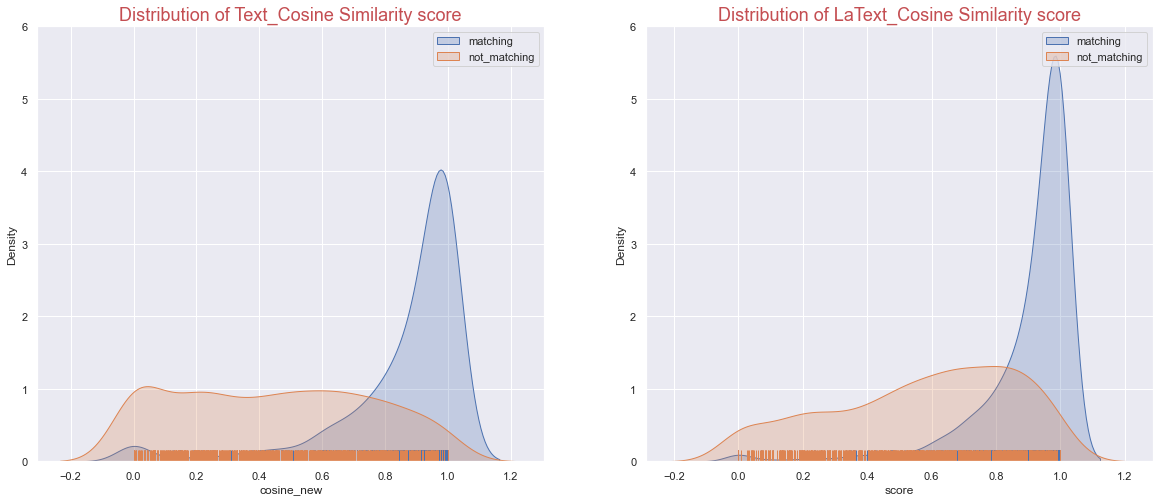

In [92]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
sb.distplot(df_pos.cosine_new, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = 'matching')
sb.distplot(df_neg.cosine_new, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = 'not_matching')
plt.ylim([0, 6])
plt.legend()
plt.title('Distribution of Text_Cosine Similarity score', fontsize = 18, color = 'r')
plt.subplot(122)
sb.distplot(df_pos.score, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = 'matching')
sb.distplot(df_neg.score, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = 'not_matching')
plt.ylim([0, 6])
plt.legend()
plt.title('Distribution of LaText_Cosine Similarity score', fontsize = 18, color = 'r');

In [94]:
check_list = [345, 1369, 983, 572, 896, 1855, 1539, 1824, 1779, 487, 1131, 277, 290, 1728, 1211, 1536, 1628,
              859, 1152, 158, 103, 120, 891, 1570, 1087, 1424, 1409, 722, 493, 1323, 1533, 842, 419, 393, 1032,
              271, 1552, 1155, 1893, 675, 1370, 1381, 1960, 1102, 1661, 745, 1635, 1568, 795, 1637, 1744, 316, 89,
              1764, 702, 494, 1564, 1153, 1753, 407, 1004, 1233, 1365, 1266, 10, 1569, 614, 758, 1547, 1455, 520, 
              267, 1287, 1060, 599, 1128, 274, 796, 1326, 222, 424, 510, 1452, 681, 935, 488, 1940, 1531, 985, 150, 
              1454, 1374, 187, 379, 289, 1183, 1739, 263, 1774, 161, 1410, 1133, 1693, 594, 1606, 1419, 1017, 1008,
              508, 1574, 458, 1554, 1025, 294, 1462, 1562, 993, 444, 604, 564, 101, 1268, 1245, 593, 1383, 354, 84,
              3, 1483, 517, 74, 1097, 1480, 1754, 1071, 457, 326]

In [97]:
adjust_fb2 = [282, 1731, 967, 1826, 281, 1801, 440, 192, 406, 750, 395, 60, 1011, 568, 146]

In [98]:
adjust_fb3 = [8, 1356, 1099, 1088, 1526, 660, 955, 34, 1453, 998, 1621, 1429, 293, 237]

In [100]:
adjust_fb4 = [465, 1264, 980, 1503, 333, 412, 1732, 1399, 381, 1226, 959]

In [101]:
adjust_fb5 = [686, 1822, 1557, 1136, 1907, 1478, 1049, 411, 1436]

In [102]:
adjust_fb6 = [1384, 230, 476, 1447, 696]

In [103]:
adjust_fb7 = [723, 1158, 1105, 100, 1246, 788, 1423, 1358, 472, 584]

In [104]:
# re-labeling to NOT MATCH
re_match = [737, 1582, 845]

In [105]:
re_match2 = [820, 1908, 1579]

In [106]:
re_match3 = [1258]

In [107]:
re_match4 = [1614]